# Gradient Descent and Backpropagation
### Understanding the math behind gradient descent and how to implement backprogagation in python
--------------------
**Author: Jay Mody**

**Required Knowledge:**
- Basic Python Skills
- Numpy
- Calculus (derivatives, gradients, chain rule)
- Linear Algebra (matrices, matrix multiplication)

## Data

In [1]:
#### Imports ####
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_blobs


#### Data Parameters ####
n_features = 2  # n_input_nodes
n_classes = 2 # n_output_nodes

n_training_samples = 300 
n_testing_samples = 200

cluster_std = 0.2
center_box = (-1, 1)

colors_list = ['red', 'cyan', 'magenta', 'green', 'black', 'blue']
colors = ListedColormap(colors_list)

seed = 2



#### Training Data ####
x_train, y_train_raw = make_blobs(n_samples = n_training_samples, 
                                  n_features = n_features,
                                  centers = n_classes,
                                  center_box = center_box,
                                  cluster_std =  cluster_std, 
                                  random_state = seed)

# One-hot encodes the y values (categorically encoding the data)
y_train = np.zeros((y_train_raw.shape[0], n_classes))
y_train[np.arange(y_train_raw.size), y_train_raw] = 1



#### Testing Data ####
x_test, y_test_raw = make_blobs(n_samples = n_testing_samples + n_training_samples, 
                            n_features = n_features,
                            centers = n_classes,
                            center_box = center_box,
                            cluster_std =  cluster_std, 
                            random_state = seed)
x_test = x_test[-n_testing_samples:]
y_test_raw = y_test_raw[-n_testing_samples:]

# One-hot encodes the y values (categorically encoding the data)
y_test = np.zeros((y_test_raw.shape[0], n_classes))
y_test[np.arange(y_test_raw.size), y_test_raw] = 1

### Datasets

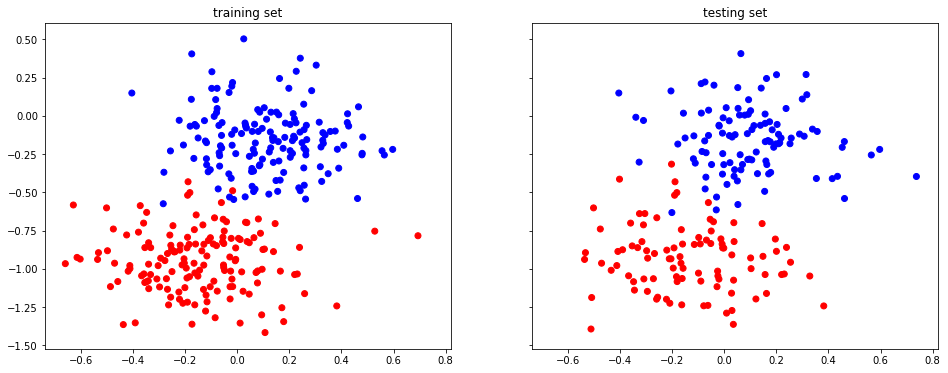

In [2]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, sharex = True, figsize=(16, 6))

_ = ax1.scatter(x_train[:, 0], x_train[:, 1], c = y_train_raw, cmap = colors)
_ = ax1.set_title('training set')

_ = ax2.scatter(x_test[:, 0], x_test[:, 1], c = y_test_raw, cmap = colors)
_ = ax2.set_title('testing set')

## Neural Network

In [3]:
#### Neural Network Class ####
class NeuralNetwork:
    ##### Constructor ####
    def __init__(self, n_input_nodes, n_hidden_nodes, n_output_nodes, lr):
        ## Network ##
        self.n_input_nodes = n_input_nodes
        self.n_hidden_nodes = n_hidden_nodes
        self.n_output_nodes = n_output_nodes
        
        ## Weights and Biases##
        # Weights and biases initialized with a uniform random distribution
        self.weights_i_h = np.random.uniform(-1.0, 1.0, (self.n_input_nodes, self.n_hidden_nodes))
        self.weights_h_o = np.random.uniform(-1.0, 1.0, (self.n_hidden_nodes, self.n_output_nodes))
        self.bias_i_h = np.random.uniform(-1.0, 1.0, (1, self.n_hidden_nodes))
        self.bias_h_o = np.random.uniform(-1.0, 1.0, (1, self.n_output_nodes))
        
        ## Learning Rate ##
        self.lr = lr
        
        ## Activation Functions ##
        # Linear Activation
        self.relu = lambda x: x
        self.d_relu = lambda x: np.ones(x.shape)
            
        # Sigmoid Activation
        self.sigmoid = lambda x: 1 / (1 + np.exp(-x))
        self.d_sigmoid = lambda x: x * (1 - x)  # assuming sigmoid has already applied to x
    
    #### Feed Forward ####
    def feed_forward(self, X):
        # Hidden Layer
        hidden_inputs = np.dot(X, self.weights_i_h) + self.bias_i_h
        hidden_outputs = self.sigmoid(hidden_inputs)
                
        # Output Layer
        y_hat_raw = np.dot(hidden_outputs, self.weights_h_o) + self.bias_h_o
        y_hat = self.sigmoid(y_hat_raw)
        
#         print("Shapes")
#         print("W1:", self.weights_i_h.shape, sep = "\t")
#         print("W2:", self.weights_h_o.shape, sep = "\t")
#         print()
#         print("X:", X.shape, sep = "\t")
#         print("Y_Hat:", y_hat.shape, sep = "\t")
#         print("H_out:", hidden_outputs.shape, sep = "\t")
#         print()
        
        return hidden_outputs, y_hat
    
    #### Backpropagation ####
    def backpropagation(self, X, y, y_hat, hidden_outputs):
        
#         print("Backpropagation")
#         print("X:", X.shape, sep = "\t")
#         print("Y:", y.shape, sep = "\t")
#         print("Y_Hat:", y_hat.shape, sep = "\t")
#         print("H_out:", hidden_outputs.shape, sep = "\t")
#         print()
        
        # Output Layer
        d1 = y - y_hat
        d2 = self.d_sigmoid(y_hat)
        output_error = d1 * d2
        
#         print("D1:", d1.shape, sep = "\t")
#         print("D2:", d2.shape, sep = "\t")
#         print("O_Err:", output_error.shape, sep = "\t")
        
        # Hidden Layer
        d3 = self.weights_h_o
        d4 = self.d_sigmoid(hidden_outputs)
        hidden_error = np.dot(output_error, d3.T) * d4
        
#         print("D3:", d3.shape, sep = "\t")
#         print("D4:", d4.shape, sep = "\t")
#         print("H_Err:", hidden_error.shape, sep = "\t")
#         print()
        
        # Gradients
        output_grad = hidden_outputs.T * output_error
        hidden_grad = X.T * hidden_error
        
        return hidden_grad, hidden_error, output_grad, output_error
    
    #### Training ####
    def train(self, features, targets):
        # Batch Size for weight update step
        batch_size = features.shape[0]
        
        # Delta Weights Variables
        delta_weights_i_h = np.zeros(self.weights_i_h.shape)
        delta_weights_h_o = np.zeros(self.weights_h_o.shape)
        delta_bias_i_h = np.zeros(self.bias_i_h.shape)
        delta_bias_h_o = np.zeros(self.bias_h_o.shape)
        
        # For every data point, forward pass, backpropogation, store weights change
        for X, y in zip(features, targets):
            # Forward pass
            X = X.reshape(1, X.shape[0])
            hidden_outputs, y_hat = self.feed_forward(X)
            
            # Back propogation
            hidden_grad, bias_h_grad, output_grad, bias_o_grad = self.backpropagation(X, y, y_hat, hidden_outputs)
            
            # Weights
            delta_weights_i_h += hidden_grad
            delta_weights_h_o += output_grad
            # Bias
            delta_bias_i_h += bias_h_grad
            delta_bias_h_o += bias_o_grad
        
        
        # Update Weights and biases
        self.weights_i_h += (self.lr * delta_weights_i_h) / batch_size
        self.weights_h_o += (self.lr * delta_weights_h_o) / batch_size 
        self.bias_i_h += (self.lr * delta_bias_i_h) / batch_size
        self.bias_h_o += (self.lr * delta_bias_h_o) / batch_size
    
    #### Testing Methods ####
    def predict(self, X):
        # Gives prediction
        return self.feed_forward(X)[1]
    
    def test(self, features, targets):
        predictions = self.predict(features)

        n_correct = 0
        for i in range(len(predictions)):
            prediction = np.argmax(predictions[i])
            correct = np.argmax(targets[i])

            if prediction == correct:
                n_correct += 1

        return n_correct / len(targets)

## Network and Parameters

In [4]:
def MSE(y, y_hat):
    return np.mean((y-y_hat)**2)

#### Network Parameters ####
n_input_nodes = n_features
n_output_nodes = n_classes

n_hidden_nodes = 64

n_epochs = 5000
lr = 0.1
batch_size = 128

#### Neural Network ####
network = NeuralNetwork(n_input_nodes, n_hidden_nodes, n_output_nodes, lr)

### Control Test

In [5]:
print("Accuracy on Train Set:", network.test(x_train, y_train))
print("Accuracy on Train Set:", network.test(x_test, y_test))

Accuracy on Train Set: 0.5
Accuracy on Train Set: 0.525


## Train

In [6]:
#### Train ####
losses = {'train':[], 'validation':[]}

for epoch in range(n_epochs):
    batch_indices = np.random.choice(list(range(x_train.shape[0])), size = batch_size)
    features = np.array([x_train[i] for i in batch_indices])
    targets = np.array([y_train[i] for i in batch_indices])
    
    network.train(features, targets)
    
    # Printing out the training progress
    train_loss = MSE(network.predict(x_train).T, y_train_raw)
    val_loss = MSE(network.predict(x_test).T, y_test_raw)
    sys.stdout.write("\rProgress: {:2.1f}%".format(100 * epoch/float(n_epochs)) \
                     + " ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

Progress: 100.0% ... Training loss: 0.441 ... Validation loss: 0.439

### Loss Graph

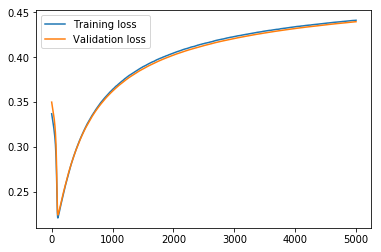

In [7]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()
plt.show()

## Testing

In [8]:
print("Accuracy on Train Set:", network.test(x_train, y_train))
print("Accuracy on Train Set:", network.test(x_test, y_test))

Accuracy on Train Set: 0.9866666666666667
Accuracy on Train Set: 0.97


In [9]:
#### END OF NOTEBOOK ####